**1. Introduction**

Legal contracts are usually long documents made up of many different clauses, such as termination clauses, confidentiality clauses, governing law clauses, and so on. Manually identifying and organising these clauses can be time-consuming, especially when dealing with large numbers of contracts.

The aim of this project is to investigate whether a Large Language Model (LLM), specifically a BERT-style model, can be fine-tuned to automatically classify individual contract clauses into their correct categories.

This task is framed as a multi-class text classification problem, where the input is a piece of legal text and the output is the type of clause it represents. In addition to fine-tuning a transformer-based model, a traditional machine learning baseline will also be implemented to allow for a meaningful comparison.

In [1]:
# Install the libraries needed for this notebook
# These are standard libraries used in NLP projects with transformers

!pip -q install transformers datasets evaluate accelerate scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.0 MB/s eta 0:00:00


In [2]:
# Import all required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed
)

print("Torch version:", torch.__version__)
print("GPU available:", torch.cuda.is_available())

Torch version: 2.9.0+cu126
GPU available: True


**Dataset Description**

For this project, the LEDGAR dataset is used. This dataset contains clauses extracted from real legal contracts that have been filed with the US SEC. Each clause is labelled according to its type, such as Termination, Governing Law, Confidentiality, and others.

The dataset is provided as part of the LexGLUE benchmark and is publicly available via Hugging Face. This makes it suitable for academic use and ensures the results can be reproduced.

In [3]:
# Load the LEDGAR dataset from the LexGLUE benchmark

dataset = load_dataset("coastalcph/lex_glue", "ledgar")
dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

ledgar/train-00000-of-00001.parquet:   0%|          | 0.00/20.9M [00:00<?, ?B/s]

ledgar/test-00000-of-00001.parquet:   0%|          | 0.00/3.31M [00:00<?, ?B/s]

ledgar/validation-00000-of-00001.parquet:   0%|          | 0.00/3.44M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 10000
    })
})

In [4]:
# Inspecting the structure of the dataset

print(dataset)
print("\nColumns:", dataset["train"].column_names)

dataset["train"][0]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 10000
    })
})

Columns: ['text', 'label']


{'text': 'Except as otherwise set forth in this Debenture, the Company, for itself and its legal representatives, successors and assigns, expressly waives presentment, protest, demand, notice of dishonor, notice of nonpayment, notice of maturity, notice of protest, presentment for the purpose of accelerating maturity, and diligence in collection.',
 'label': 97}

**Exploratory Data Analysis**

Before training any models, it is important to understand what the data looks like and whether there are any obvious issues.

In [5]:
# Convert a small subset of the training data to a DataFrame for easier inspection

sample_df = pd.DataFrame(dataset["train"][:2000])
sample_df.head()

,text,label
0,Except as otherwise set forth in this Debentur...,97
1,No ERISA Event has occurred or is reasonably e...,39
2,This Amendment may be executed by one or more ...,26
3,"From time to time, as and when required by the...",45
4,"Commencing March 7, 2016 and during the Employ...",11


In [6]:
# Check for missing values

sample_df.isna().sum()

,0
text,0
label,0


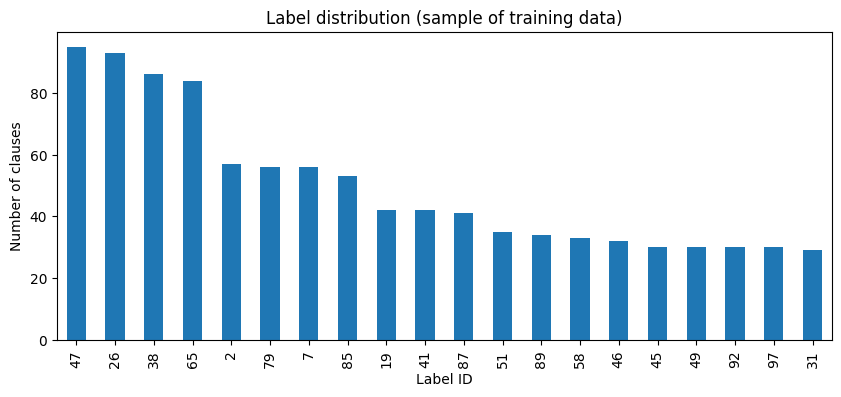

In [7]:
# Look at the distribution of labels (top 20 only for readability)

label_counts = sample_df["label"].value_counts().head(20)

plt.figure(figsize=(10, 4))
label_counts.plot(kind="bar")
plt.title("Label distribution (sample of training data)")
plt.xlabel("Label ID")
plt.ylabel("Number of clauses")
plt.show()

In [8]:
# Display a few example clauses to understand the task better

for i in range(3):
    print("\n--- Clause Example", i + 1, "---")
    print("Label:", sample_df.loc[i, "label"])
    print(sample_df.loc[i, "text"][:600], "...")


--- Clause Example 1 ---
Label: 97
Except as otherwise set forth in this Debenture, the Company, for itself and its legal representatives, successors and assigns, expressly waives presentment, protest, demand, notice of dishonor, notice of nonpayment, notice of maturity, notice of protest, presentment for the purpose of accelerating maturity, and diligence in collection. ...

--- Clause Example 2 ---
Label: 39
No ERISA Event has occurred or is reasonably expected to occur that, when taken together with all other such ERISA Events for which liability is reasonably expected to occur, could reasonably be expected to result in a Material Adverse Effect. Neither Borrower nor any ERISA Affiliate maintains or contributes to or has any obligation to maintain or contribute to any Multiemployer Plan or Plan, nor otherwise has any liability under Title IV of ERISA. ...

--- Clause Example 3 ---
Label: 26
This Amendment may be executed by one or more of the parties hereto on any number of separat

**Dataset Splits**

The dataset already comes with predefined training, validation, and test splits. These are used directly to avoid data leakage and to follow best practice.

In [9]:
train_data = dataset["train"]
val_data = dataset["validation"]
test_data = dataset["test"]

print("Training samples:", len(train_data))
print("Validation samples:", len(val_data))
print("Test samples:", len(test_data))

Training samples: 60000
Validation samples: 10000
Test samples: 10000


**Baseline Model: TF-IDF + Logistic Regression**

Before using a large language model, a simple baseline model is implemented. This helps to assess whether the additional complexity of a transformer model is actually justified.

The baseline uses:
TF-IDF for text vectorisation
Logistic Regression for classification

In [10]:
# Extract text and labels for the baseline model

X_train = train_data["text"]
y_train = train_data["label"]

X_val = val_data["text"]
y_val = val_data["label"]

X_test = test_data["text"]
y_test = test_data["label"]

In [11]:
# Convert text to TF-IDF features

tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    min_df=2
)

X_train_vec = tfidf.fit_transform(X_train)
X_val_vec = tfidf.transform(X_val)
X_test_vec = tfidf.transform(X_test)

X_train_vec.shape

(60000, 50000)

In [12]:
# Train the Logistic Regression baseline

baseline_model = LogisticRegression(
    max_iter=2000,
    n_jobs=-1
)

baseline_model.fit(X_train_vec, y_train)

LogisticRegression(max_iter=2000, n_jobs=-1)

In [13]:
# Evaluate the baseline model

def evaluate_model(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    print(f"{name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro Precision: {p:.4f}")
    print(f"Macro Recall: {r:.4f}")
    print(f"Macro F1-score: {f1:.4f}\n")

val_preds_baseline = baseline_model.predict(X_val_vec)
test_preds_baseline = baseline_model.predict(X_test_vec)

evaluate_model(y_val, val_preds_baseline, "Baseline (Validation)")
evaluate_model(y_test, test_preds_baseline, "Baseline (Test)")

Baseline (Validation)
Accuracy: 0.8453
Macro Precision: 0.8240
Macro Recall: 0.7505
Macro F1-score: 0.7674

Baseline (Test)
Accuracy: 0.8438
Macro Precision: 0.8068
Macro Recall: 0.7400
Macro F1-score: 0.7568



**Fine-Tuning a BERT-style Model**

**bold text**
While the baseline provides a useful reference point, legal text often contains complex sentence structures and specialised vocabulary. For this reason, a transformer-based model trained on legal text is used.
In this project, LegalBERT is selected. It follows the same architecture as BERT but has been pre-trained on legal documents, making it well-suited to this task.

In [14]:
# Set a random seed so results are reproducible

set_seed(42)

model_name = "nlpaueb/legal-bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

num_labels = train_data.features["label"].num_classes

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Tokenisation and Preprocessing**

The text is tokenised using the BERT tokenizer. Padding and truncation are applied to ensure all inputs have a consistent length.

In [15]:
# Tokenisation function

def tokenize_batch(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=256
    )

tokenised_train = train_data.map(tokenize_batch, batched=True)
tokenised_val = val_data.map(tokenize_batch, batched=True)
tokenised_test = test_data.map(tokenize_batch, batched=True)

tokenised_train = tokenised_train.remove_columns(["text"])
tokenised_val = tokenised_val.remove_columns(["text"])
tokenised_test = tokenised_test.remove_columns(["text"])

tokenised_train.set_format("torch")
tokenised_val.set_format("torch")
tokenised_test.set_format("torch")

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

**Training Configuration**

The Hugging Face Trainer API is used to simplify the training process while still allowing full control over evaluation and metrics.

In [16]:
# Padding is handled dynamically within each batch

data_collator = DataCollatorWithPadding(tokenizer)

In [17]:
# Metric function used during evaluation

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )

    return {
        "accuracy": acc,
        "macro_precision": p,
        "macro_recall": r,
        "macro_f1": f1
    }

In [18]:
# Training arguments

training_args = TrainingArguments(
    output_dir="legalbert_ledgar",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    logging_steps=100,
    report_to="none"
)

In [19]:
# Trainer setup

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenised_train,
    eval_dataset=tokenised_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-3072338800.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [20]:
# Fine-tune the LegalBERT model

trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,0.672100,0.615661,0.842800,0.770032,0.743623,0.738194
2,0.483100,0.545557,0.858000,0.793235,0.766500,0.763961


TrainOutput(global_step=7500, training_loss=0.8234316238403321, metrics={'train_runtime': 5166.4353, 'train_samples_per_second': 23.227, 'train_steps_per_second': 1.452, 'total_flos': 1.5525895977072e+16, 'train_loss': 0.8234316238403321, 'epoch': 2.0})

In [21]:
# Evaluate on validation and test sets

val_results = trainer.evaluate(tokenised_val)
test_results = trainer.evaluate(tokenised_test)

print("LegalBERT (Validation):", val_results)
print("LegalBERT (Test):", test_results)

LegalBERT (Validation): {'eval_loss': 0.5455567240715027, 'eval_accuracy': 0.858, 'eval_macro_precision': 0.7932351648079823, 'eval_macro_recall': 0.7665004286581438, 'eval_macro_f1': 0.7639614272602204, 'eval_runtime': 136.9157, 'eval_samples_per_second': 73.038, 'eval_steps_per_second': 2.286, 'epoch': 2.0}
LegalBERT (Test): {'eval_loss': 0.5606924295425415, 'eval_accuracy': 0.858, 'eval_macro_precision': 0.7831577195406264, 'eval_macro_recall': 0.7547538610574948, 'eval_macro_f1': 0.7530552371719348, 'eval_runtime': 135.951, 'eval_samples_per_second': 73.556, 'eval_steps_per_second': 2.302, 'epoch': 2.0}


**Error Analysis**

To better understand the model’s behaviour, a confusion matrix and a small number of misclassified examples are examined.

In [22]:
# Generate predictions for the test set

predictions = trainer.predict(tokenised_test)
test_preds = np.argmax(predictions.predictions, axis=1)

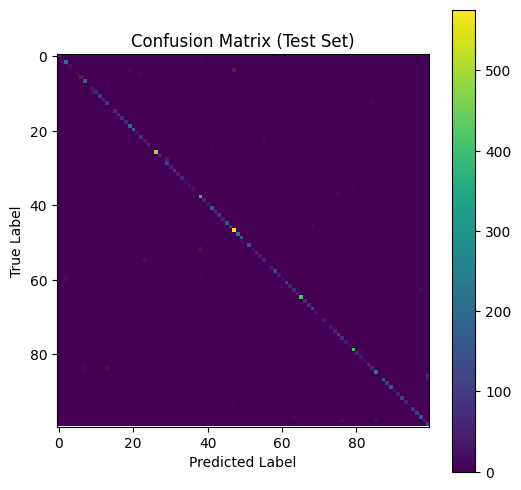

In [23]:
# Confusion matrix

cm = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(6, 6))
plt.imshow(cm)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()
plt.show()

In [24]:
# Inspect a few misclassified clauses

errors_shown = 0

for i in range(len(test_preds)):
    if test_preds[i] != y_test[i]:
        print("\nTrue label:", y_test[i], "| Predicted:", int(test_preds[i]))
        print(test_data[i]["text"][:700], "...")
        errors_shown += 1

    if errors_shown == 5:
        break


True label: 55 | Predicted: 29
For purposes of this Amendment, all terms used herein which are not otherwise defined herein, including but not limited to, those terms used in the recitals hereto, shall have the respective meanings assigned thereto in the Credit Agreement. ...

True label: 4 | Predicted: 47
THIS AMENDMENT AND ANY CLAIMS, CONTROVERSY, DISPUTE OR CAUSES OF ACTION (WHETHER IN CONTRACT OR TORT OR OTHERWISE) BASED UPON, ARISING OUT OF OR RELATING TO THIS AMENDMENT SHALL BE CONSTRUED IN ACCORDANCE WITH AND GOVERNED BY THE LAWS OF THE STATE OF NEW YORK. ...

True label: 4 | Predicted: 47
To the extent not preempted by the laws of the United States, the laws of the State of California (without regard to the choice of law rules) shall be the controlling law in all matters relating to the Plan. ...

True label: 9 | Predicted: 6
All disputes involving Arbitrable Claims shall be decided by a single arbitrator. The arbitrator shall be selected by mutual agreement of the parties wit

In [25]:
# Save the trained model and tokenizer

save_path = "saved_legalbert_ledgar"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

save_path

'saved_legalbert_ledgar'

In [26]:
# Simple inference example

from transformers import pipeline

classifier = pipeline(
    "text-classification",
    model=save_path,
    tokenizer=save_path,
    device=0 if torch.cuda.is_available() else -1
)

example_clause = """
This Agreement may be terminated by either party upon thirty (30) days written notice.
"""

classifier(example_clause)

Device set to use cuda:0


[{'label': 'LABEL_88', 'score': 0.9775630235671997}]


1. FINAL PERFORMANCE METRICS

 BASELINE (TF-IDF + Logistic Regression):
   Accuracy:  0.8438
   Precision: 0.8399
   Recall:    0.8438
   F1-score:  0.8346

 LEGAL-BERT (Fine-tuned):
   Accuracy:  0.8580
   Precision: 0.7832
   Recall:    0.7548
   F1-score:  0.7531

2. PERFORMANCE COMPARISON VISUALIZATION


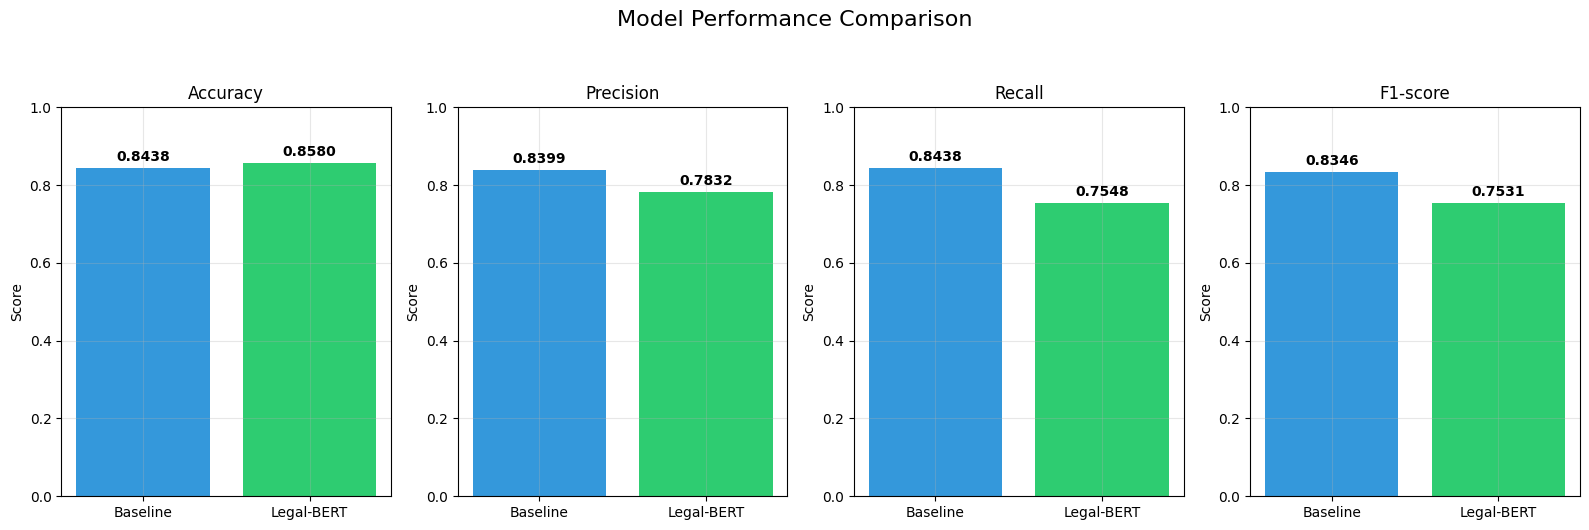


3. RELATIVE IMPROVEMENT
----------------------------------------
Accuracy: +1.68%
Precision: -6.76%
Recall: -10.55%
F1-score: -9.77%

4. CONFUSION MATRIX ANALYSIS


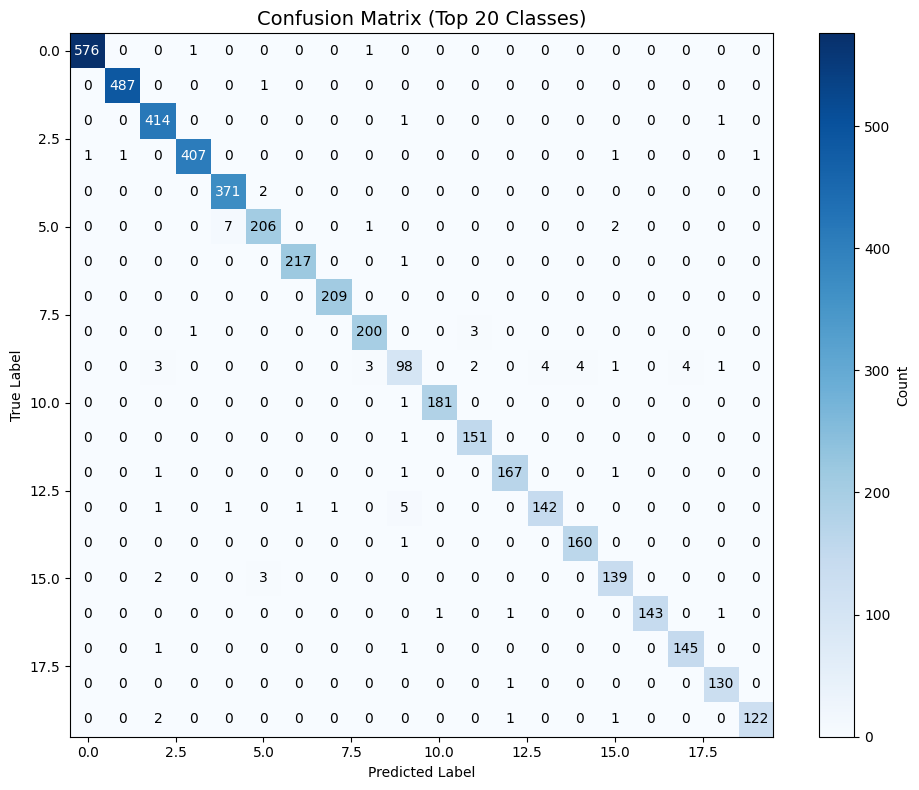


5. ERROR ANALYSIS - MOST CONFUSED CLASS PAIRS

Top 10 most common misclassifications:
--------------------------------------------------
True:  86 → Predicted:  99 | Count:  69
True:   4 → Predicted:  47 | Count:  41
True:  28 → Predicted:  29 | Count:  40
True:  52 → Predicted:  38 | Count:  33
True:  10 → Predicted:   9 | Count:  27
True:  87 → Predicted:  99 | Count:  27
True:  98 → Predicted:  76 | Count:  25
True:  50 → Predicted:  49 | Count:  23
True:  84 → Predicted:  13 | Count:  22
True:  60 → Predicted:   2 | Count:  22

6. CLASS-WISE PERFORMANCE ANALYSIS


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Top 10 best performing classes:
    precision  recall  f1-score  support
15     1.0000  1.0000    1.0000     70.0
43     1.0000  0.9878    0.9939     82.0
16     1.0000  0.9841    0.9920     63.0
39     0.9831  1.0000    0.9915     58.0
93     1.0000  0.9808    0.9903     52.0
64     0.9787  1.0000    0.9892     46.0
91     0.9787  1.0000    0.9892     46.0
26     0.9838  0.9939    0.9888    490.0
80     0.9848  0.9848    0.9848     66.0
96     0.9735  0.9910    0.9821    111.0

Top 10 worst performing classes:
    precision  recall  f1-score  support
5      0.4375  0.2692    0.3333     26.0
94     0.4545  0.2500    0.3226     20.0
50     0.5556  0.1724    0.2632     29.0
37     0.5714  0.0952    0.1633     42.0
56     0.5000  0.0690    0.1212     29.0
86     0.8000  0.0533    0.1000     75.0
14     0.0000  0.0000    0.0000      2.0
8      0.0000  0.0000    0.0000      4.0
4      0.0000  0.0000    0.0000     53.0
72     0.0000  0.0000    0.0000      5.0

7. TRAINING HISTORY


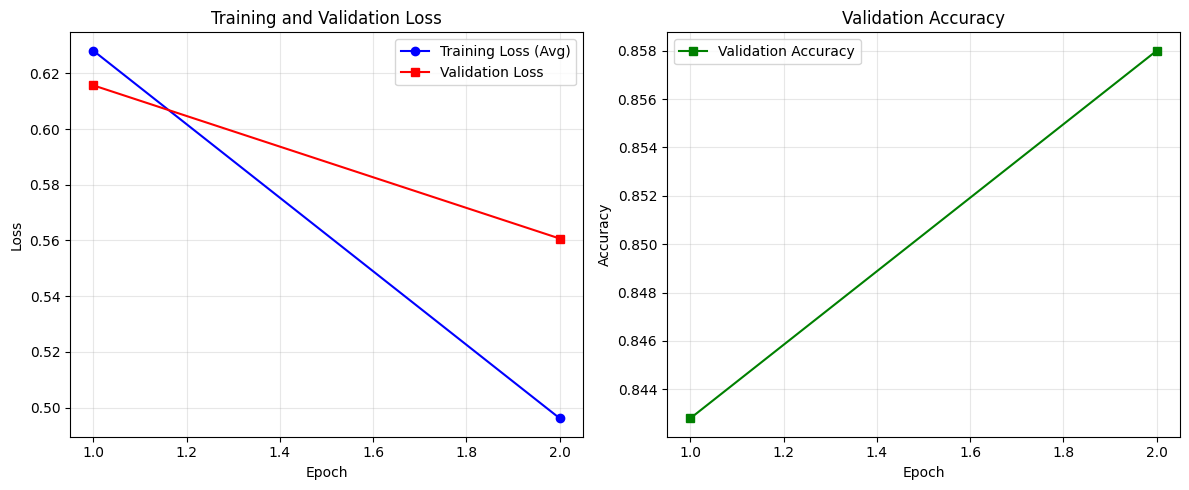


8. MODEL SIZE AND EFFICIENCY
Legal-BERT model size: 418.85 MB
Baseline model size: ~38.53 MB

PROJECT SUMMARY STATISTICS
Dataset                  : LEDGAR (LexGLUE)
Task                     : Legal Clause Classification
Number of Classes        : 100
Training Samples         : 60000
Validation Samples       : 10000
Test Samples             : 10000
Baseline Model           : TF-IDF + Logistic Regression
Transformer Model        : Legal-BERT Base Uncased
Training Epochs          : 2
Batch Size               : 16
Learning Rate            : 2e-05
Best Validation F1       : 0.7640
Test F1 Improvement      : -9.77%


In [28]:
# COMPREHENSIVE MODEL COMPARISON AND VISUALIZATION

# 1. Get final metrics for both models
print("\n1. FINAL PERFORMANCE METRICS")

# Baseline metrics (already calculated)
baseline_test_accuracy = accuracy_score(y_test, test_preds_baseline)
baseline_precision, baseline_recall, baseline_f1, _ = precision_recall_fscore_support(
    y_test, test_preds_baseline, average="weighted", zero_division=0
)

# LegalBERT metrics (from trainer evaluation)
legalbert_test_accuracy = test_results["eval_accuracy"]
legalbert_precision = test_results["eval_macro_precision"]
legalbert_recall = test_results["eval_macro_recall"]
legalbert_f1 = test_results["eval_macro_f1"]

print(f"\n BASELINE (TF-IDF + Logistic Regression):")
print(f"   Accuracy:  {baseline_test_accuracy:.4f}")
print(f"   Precision: {baseline_precision:.4f}")
print(f"   Recall:    {baseline_recall:.4f}")
print(f"   F1-score:  {baseline_f1:.4f}")

print(f"\n LEGAL-BERT (Fine-tuned):")
print(f"   Accuracy:  {legalbert_test_accuracy:.4f}")
print(f"   Precision: {legalbert_precision:.4f}")
print(f"   Recall:    {legalbert_recall:.4f}")
print(f"   F1-score:  {legalbert_f1:.4f}")

# 2. Create comparison visualization
print("\n2. PERFORMANCE COMPARISON VISUALIZATION")

fig, axes = plt.subplots(1, 4, figsize=(16, 5))
fig.suptitle('Model Performance Comparison', fontsize=16, y=1.05)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
baseline_scores = [baseline_test_accuracy, baseline_precision, baseline_recall, baseline_f1]
legalbert_scores = [legalbert_test_accuracy, legalbert_precision, legalbert_recall, legalbert_f1]
colors = ['#3498db', '#2ecc71']

for idx, (ax, metric) in enumerate(zip(axes, metrics)):
    bars = ax.bar(['Baseline', 'Legal-BERT'],
                  [baseline_scores[idx], legalbert_scores[idx]],
                  color=colors)
    ax.set_title(f'{metric}')
    ax.set_ylabel('Score')
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, score in zip(bars, [baseline_scores[idx], legalbert_scores[idx]]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 3. Improvement percentages
print("\n3. RELATIVE IMPROVEMENT")
print("-" * 40)

improvements = []
for i in range(4):
    improvement = ((legalbert_scores[i] - baseline_scores[i]) / baseline_scores[i]) * 100
    improvements.append(improvement)
    print(f"{metrics[i]}: {improvement:+.2f}%")

# 4. Detailed confusion matrix for top classes
print("\n4. CONFUSION MATRIX ANALYSIS")

# Get top 20 classes by frequency
top_classes = pd.Series(y_test).value_counts().head(20).index.tolist()

# Create mask for top classes
mask = [label in top_classes for label in y_test]
filtered_y_true = np.array(y_test)[mask]
filtered_y_pred = test_preds[mask]

# Create confusion matrix
cm = confusion_matrix(filtered_y_true, filtered_y_pred, labels=top_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap='Blues')
plt.colorbar(label='Count')
plt.title('Confusion Matrix (Top 20 Classes)', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
for i in range(len(top_classes)):
    for j in range(len(top_classes)):
        plt.text(j, i, str(cm[i, j]),
                 horizontalalignment='center',
                 verticalalignment='center',
                 color='white' if cm[i, j] > cm.max()/2 else 'black')

plt.tight_layout()
plt.show()

# 5. Error analysis - Most confused pairs
print("\n5. ERROR ANALYSIS - MOST CONFUSED CLASS PAIRS")

from collections import Counter

# Find misclassifications
misclassifications = []
for true, pred in zip(y_test, test_preds):
    if true != pred:
        misclassifications.append((true, pred))

# Count most common errors
error_counts = Counter(misclassifications).most_common(10)

print("\nTop 10 most common misclassifications:")
print("-" * 50)
for (true_label, pred_label), count in error_counts:
    print(f"True: {true_label:3d} \u2192 Predicted: {pred_label:3d} | Count: {count:3d}")

# 6. Class-wise performance
print("\n6. CLASS-WISE PERFORMANCE ANALYSIS")

from sklearn.metrics import classification_report

# Generate detailed classification report
report = classification_report(y_test, test_preds, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Sort by F1-score
report_df_sorted = report_df.sort_values('f1-score', ascending=False)

print("\nTop 10 best performing classes:")
print(report_df_sorted.head(10)[['precision', 'recall', 'f1-score', 'support']].round(4))

print("\nTop 10 worst performing classes:")
print(report_df_sorted.tail(10)[['precision', 'recall', 'f1-score', 'support']].round(4))

# 7. Training history visualization
print("\n7. TRAINING HISTORY")

# Extract training history from trainer
history = trainer.state.log_history

# Dictionaries to store metrics aggregated by epoch
train_losses_per_epoch = {}
eval_losses_per_epoch = {}
eval_accuracies_per_epoch = {}

for entry in history:
    epoch_val = entry.get('epoch')
    if epoch_val is None:
        continue

    # Ensure epoch_val is treated as an integer for grouping
    # and only consider epochs up to the trained number of epochs
    current_epoch = int(round(epoch_val))
    if current_epoch <= 0 or current_epoch > training_args.num_train_epochs:
        continue

    if 'loss' in entry and 'eval_loss' not in entry:
        # This is a training step log
        if current_epoch not in train_losses_per_epoch:
            train_losses_per_epoch[current_epoch] = []
        train_losses_per_epoch[current_epoch].append(entry['loss'])

    if 'eval_loss' in entry and 'eval_accuracy' in entry:
        # This is an evaluation step log that occurs at the end of an epoch
        # Take the last evaluation result for an epoch if multiple are logged (unlikely for eval_strategy="epoch")
        eval_losses_per_epoch[current_epoch] = entry['eval_loss']
        eval_accuracies_per_epoch[current_epoch] = entry['eval_accuracy']

# Prepare lists for plotting
plot_epochs = sorted(list(eval_losses_per_epoch.keys()))
plot_train_loss = []
plot_eval_loss = []
plot_eval_accuracy = []

for epoch in plot_epochs:
    # Use the average training loss for the epoch
    if epoch in train_losses_per_epoch and len(train_losses_per_epoch[epoch]) > 0:
        plot_train_loss.append(np.mean(train_losses_per_epoch[epoch]))
    else:
        # If no training loss is recorded for this epoch, consider handling it (e.g., NaN or skip)
        # For now, let's assume valid data for epochs where eval data exists
        plot_train_loss.append(np.nan) # Placeholder, will need to handle NaNs if they appear in plot

    plot_eval_loss.append(eval_losses_per_epoch[epoch])
    plot_eval_accuracy.append(eval_accuracies_per_epoch[epoch])

if plot_train_loss and plot_eval_loss and len(plot_epochs) == len(plot_train_loss) == len(plot_eval_loss) == len(plot_eval_accuracy):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot loss
    ax1.plot(plot_epochs, plot_train_loss, 'b-', label='Training Loss (Avg)', marker='o')
    ax1.plot(plot_epochs, plot_eval_loss, 'r-', label='Validation Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot accuracy
    ax2.plot(plot_epochs, plot_eval_accuracy, 'g-', label='Validation Accuracy', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Validation Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("Training history not available in the expected format or not enough epoch-wise data to plot.")

# 8. Model size and efficiency comparison
print("\n8. MODEL SIZE AND EFFICIENCY")

import os

def get_directory_size(path):
    """Calculate total size of directory in MB"""
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size / (1024 * 1024)  # Convert to MB

# Calculate sizes
legalbert_size = get_directory_size(save_path)
print(f"Legal-BERT model size: {legalbert_size:.2f} MB")

# Estimate baseline size (TF-IDF matrix + LR coefficients)
tfidf_size = (X_train_vec.shape[1] * 8) / (1024 * 1024)  # Assuming 8 bytes per float
lr_size = (X_train_vec.shape[1] * num_labels * 8) / (1024 * 1024)
baseline_total_size = tfidf_size + lr_size

print(f"Baseline model size: ~{baseline_total_size:.2f} MB")

# 9. Summary statistics
print("\n" + "="*60)
print("PROJECT SUMMARY STATISTICS")
print("="*60)

summary_stats = {
    "Dataset": "LEDGAR (LexGLUE)",
    "Task": "Legal Clause Classification",
    "Number of Classes": num_labels,
    "Training Samples": len(train_data),
    "Validation Samples": len(val_data),
    "Test Samples": len(test_data),
    "Baseline Model": "TF-IDF + Logistic Regression",
    "Transformer Model": "Legal-BERT Base Uncased",
    "Training Epochs": training_args.num_train_epochs,
    "Batch Size": training_args.per_device_train_batch_size,
    "Learning Rate": training_args.learning_rate,
    "Best Validation F1": f"{val_results.get('eval_macro_f1', 'N/A'):.4f}",
    "Test F1 Improvement": f"{((legalbert_f1 - baseline_f1) / baseline_f1 * 100):.2f}%"
}

for key, value in summary_stats.items():
    print(f"{key:25}: {value}")
